__2019春学期 人工智能程序设计 课程项目__

__花朵识别__

作者: zhx, xzh

Baseline:Transfer Learning

Slightly modified from Pytorch official code

### 库的引入

In [5]:
%matplotlib inline

In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False


### 数据集的处理

数据来源：zhx 小姐姐

In [31]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.3,0.3,0.3,0.3),
        transforms.RandomRotation(60),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



__对数据集可视化__




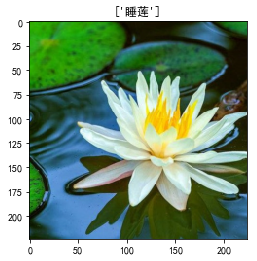

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
#Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 模型训练

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())#?   #save the model for later evaluation
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step() #Adjust the learning rate
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [33]:
#not freezed
num_classes=9
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

In [34]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.2981 Acc: 0.1017
val Loss: 1.9363 Acc: 0.3333

Epoch 1/24
----------
train Loss: 2.0995 Acc: 0.2373
val Loss: 1.7512 Acc: 0.3333

Epoch 2/24
----------
train Loss: 1.8501 Acc: 0.3898
val Loss: 1.5557 Acc: 0.5556

Epoch 3/24
----------
train Loss: 1.6944 Acc: 0.4237
val Loss: 1.3475 Acc: 0.5556

Epoch 4/24
----------
train Loss: 1.3468 Acc: 0.6441
val Loss: 1.1175 Acc: 0.6667

Epoch 5/24
----------
train Loss: 1.1814 Acc: 0.7119
val Loss: 0.8842 Acc: 0.8889

Epoch 6/24
----------
train Loss: 1.0311 Acc: 0.7627
val Loss: 0.7944 Acc: 0.7778

Epoch 7/24
----------
train Loss: 0.9435 Acc: 0.7458
val Loss: 0.7575 Acc: 0.7778

Epoch 8/24
----------
train Loss: 0.8684 Acc: 0.8305
val Loss: 0.7775 Acc: 0.7778

Epoch 9/24
----------
train Loss: 0.8997 Acc: 0.7119
val Loss: 0.7173 Acc: 0.7778

Epoch 10/24
----------
train Loss: 0.7408 Acc: 0.8814
val Loss: 0.6876 Acc: 0.7778

Epoch 11/24
----------
train Loss: 0.9113 Acc: 0.8136
val Loss: 0.6524 Acc: 0.7778

Ep

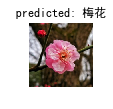

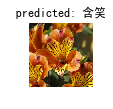

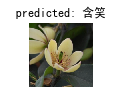

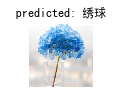

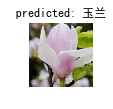

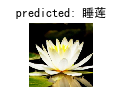

In [37]:
visualize_model(model_ft)

In [24]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False   #用model的方法

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)  #substitute the last layer

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [32]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.2069 Acc: 0.1864
val Loss: 2.1629 Acc: 0.1111

Epoch 1/24
----------
train Loss: 2.1307 Acc: 0.1864
val Loss: 2.1648 Acc: 0.1111

Epoch 2/24
----------
train Loss: 2.2460 Acc: 0.1356
val Loss: 2.1503 Acc: 0.1111

Epoch 3/24
----------
train Loss: 2.1671 Acc: 0.1525
val Loss: 2.1570 Acc: 0.1111

Epoch 4/24
----------
train Loss: 2.2182 Acc: 0.1525
val Loss: 2.1738 Acc: 0.2222

Epoch 5/24
----------
train Loss: 2.1935 Acc: 0.1695
val Loss: 2.1762 Acc: 0.2222

Epoch 6/24
----------
train Loss: 2.2062 Acc: 0.1864
val Loss: 2.1893 Acc: 0.1111

Epoch 7/24
----------
train Loss: 2.1578 Acc: 0.1695
val Loss: 2.1728 Acc: 0.2222

Epoch 8/24
----------
train Loss: 2.2767 Acc: 0.1186
val Loss: 2.1995 Acc: 0.2222

Epoch 9/24
----------
train Loss: 2.2060 Acc: 0.2203
val Loss: 2.1969 Acc: 0.1111

Epoch 10/24
----------
train Loss: 2.2546 Acc: 0.1356
val Loss: 2.1781 Acc: 0.1111

Epoch 11/24
----------
train Loss: 2.2277 Acc: 0.2034
val Loss: 2.1861 Acc: 0.2222

Ep

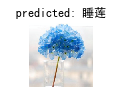

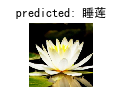

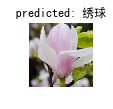

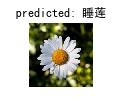

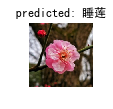

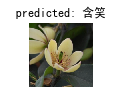

In [26]:
visualize_model(model_conv)

plt.ioff()
plt.show()